In [1]:
from DLtools.Data_preprocess import load_data
from DLtools.evaluation_rec import real_eva_error,error_rec,list_eva_error
from DLtools.Data import load_data,del_less_col,check_specific_col

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, LSTM, RepeatVector,TimeDistributed,Input
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

Inspired
https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

In [2]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df

In [3]:
loaddata = load_data()
ame = loaddata.df_rain
kawa = loaddata.df_water
tenki = loaddata.df_weather
dam = loaddata.df_dam

df_d = loaddata.daily()
df_h = loaddata.hourly()

  2%|▏         | 3/154 [00:00<00:05, 27.88it/s]START LOADING DATA 2012-2020(July)

rainfall (daily)....
356
Working on rain file.....
  0%|          | 0/113 [00:00<?, ?it/s]
Before del col are... 154
After... 123

water lv (hourly)....
149
Working on water file.....
 50%|█████     | 57/113 [02:02<01:58,  2.11s/it]

In [4]:
# r='data/instant_data/rain_small.csv'
# w='data/instant_data/water_small.csv'
# rw = load_data(r,w)
# df =rw.df.resample('d').mean().astype('float32')

df = df_d["2013-01-01":"2017-12-31"].interpolate(limit=360).fillna(0)

In [5]:
TARGET = 'CPY015_wl'
df = move_column_inplace(df,TARGET,0)
df.head()

,CPY015_wl,BKK001_rain,BKK002_rain,BKK003_rain,BKK004_rain,BKK005_rain,BKK007_rain,BKK008_rain,BKK013_rain,BKK018_rain,...,BH_Input_WaterVol,KheawNoi_Input_WaterVol,KiewKorMa_Input_WaterVol,KiewLom_Input_WaterVol,SK_Input_WaterVol,BH_Output_WaterVol,KheawNoi_Output_WaterVol,KiewKorMa_Output_WaterVol,KiewLom_Output_WaterVol,SK_Output_WaterVol
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.797222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.27,1.60,0.0,0.46,3.40,23.0,4.32,0.04,1.28,23.090000
2013-01-02,0.636250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.25,0.0,0.12,3.44,23.0,4.32,0.04,0.12,23.030001
2013-01-03,0.581458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.53,0.90,0.0,0.56,5.50,29.0,4.32,0.04,0.12,33.150002
2013-01-04,0.532153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.59,0.55,0.0,0.52,4.47,29.0,4.32,0.04,0.12,38.099998
2013-01-05,0.530139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.55,0.0,0.52,4.94,29.0,4.32,0.04,0.12,38.459999


In [7]:
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

######################
n_past = 14
n_future = 7 
n_features = 370
data = df
# SCALE
scaler_tar = MinMaxScaler()
scaler_tar.fit(df[TARGET].to_numpy().reshape(-1,1))

scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])

# Train-Test split
split_pt = int(data.shape[0]*.7)
train,test = data.iloc[:split_pt,:],data.iloc[split_pt:,:]

#Split XY
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train[:,:,0]
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test[:,:,0]

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1258, 14, 370) (1258, 7)
(528, 14, 370) (528, 7)


# Encode,decode from machinery website

In [8]:
verbose, epochs, batch_size = 0, 70, 16
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))                                  # Decoder 
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
model.summary()
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=10, verbose=2)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
callbacks = [callback_early_stopping,reduce_lr]
# callbacks = [reduce_lr]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               456800    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 200)            320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1)              101       
Total params: 797,801
Trainable params: 797,801
Non-trainable params: 0
_________________________________________________________________


Epoch 00026: early stopping


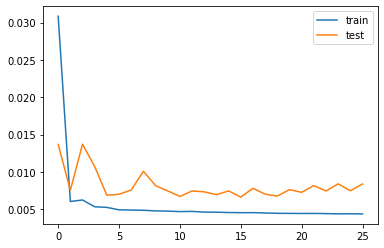

In [9]:
history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=callbacks)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
# get prdict result as once
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

scale_Y = scaler_tar.inverse_transform(y_train)
scale_Yhat = scaler_tar.inverse_transform(trainPredict.reshape(y_train.shape))

scale_Y_t = scaler_tar.inverse_transform(y_test)
scale_Yhat_t = scaler_tar.inverse_transform(testPredict.reshape(y_test.shape))

mse, nse,r2 = list_eva_error(scale_Y, scale_Yhat,n_future)
Tmse, Tnse,Tr2 = list_eva_error(scale_Y_t, scale_Yhat_t,n_future)

In [19]:
error = pd.DataFrame()
for d in range(n_future):
    error_rec(error,"LSTM_{}d".format(d),n_features,n_timesteps,'batch_size',mse[d],Tmse[d],nse[d],Tnse[d],r2[d],Tr2[d])

0.015442914423467447
0.015428100651750388
0.015258341300538268
0.01520664894458021
0.015230443342074318
0.015658514392265614
0.016161742213050924


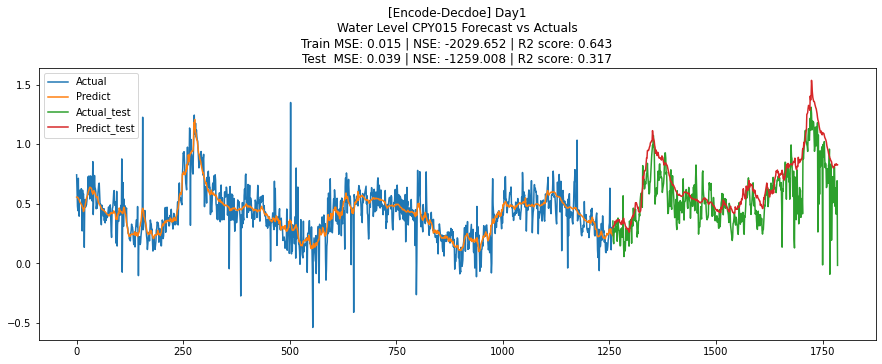

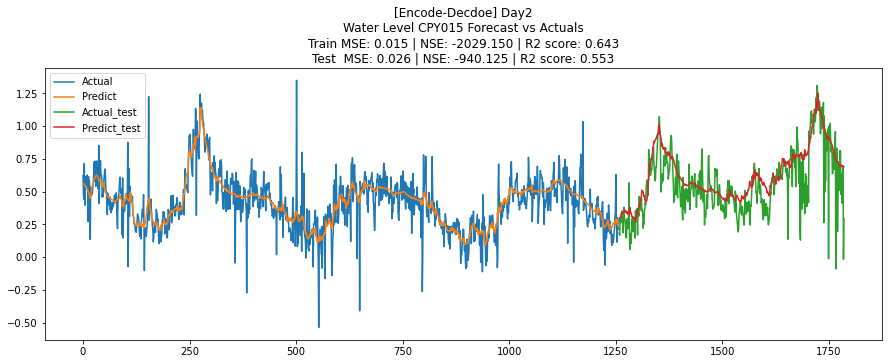

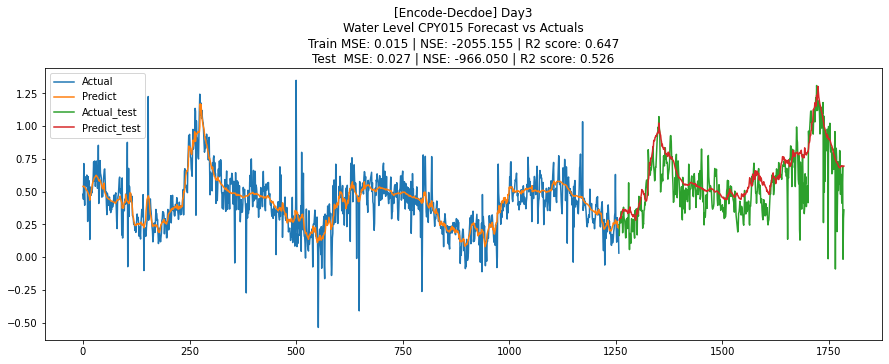

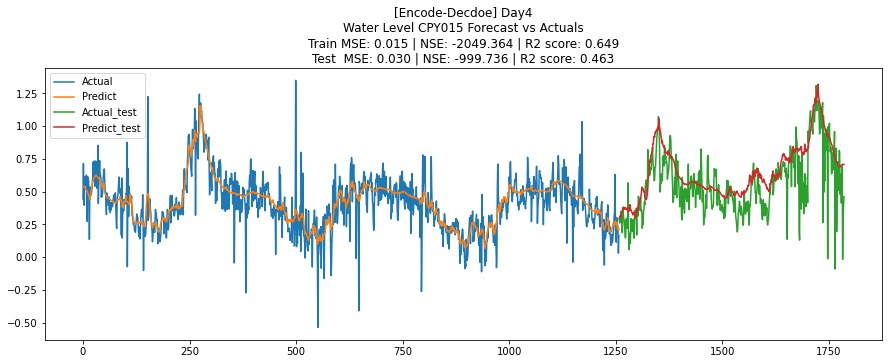

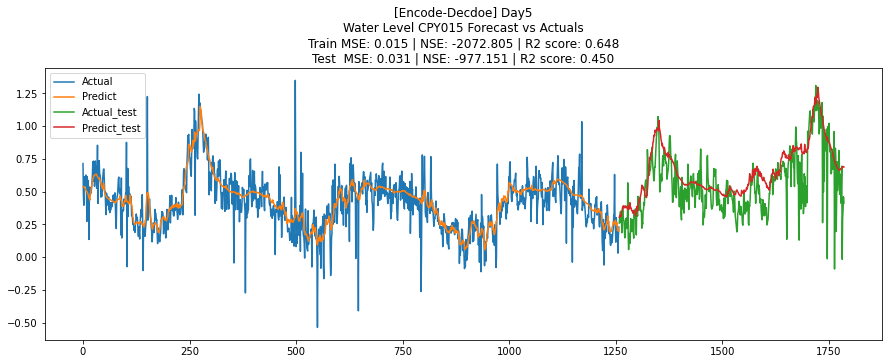

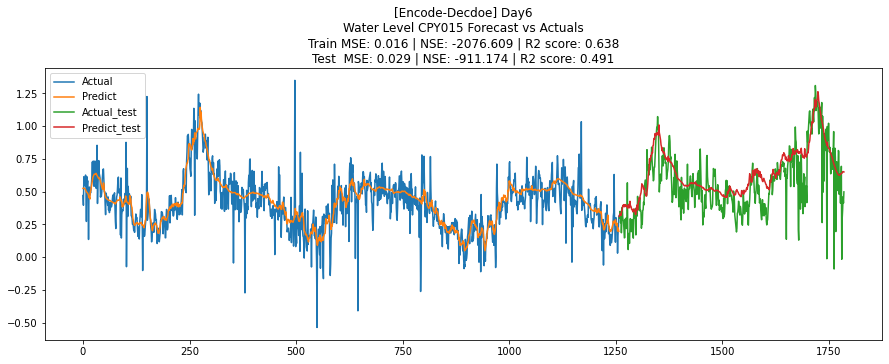

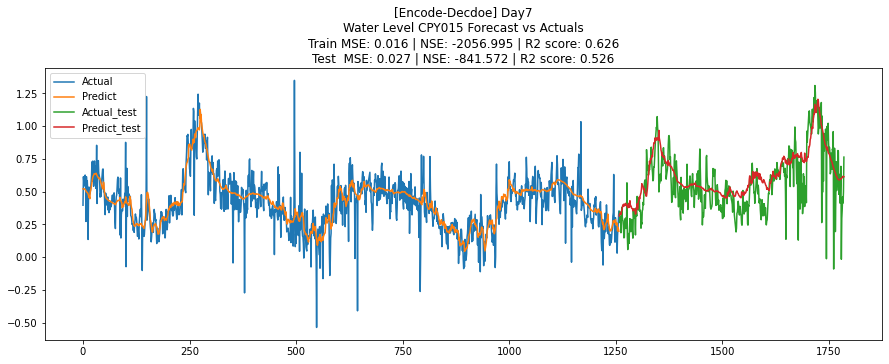

In [16]:
index = np.arange(len(y_train)+len(y_test))

for d in range(n_future):
    Y= pd.Series(data=scale_Y[:,d],index=index[:len(y_train)])
    Yhat = pd.Series(data=(scale_Yhat[:,d].ravel()),index=index[:len(y_train)])
    Y_t= pd.Series(data=scale_Y_t[:,d],index=index[-len(y_test):])
    Yhat_t = pd.Series(data=(scale_Yhat_t[:,d].ravel()),index=index[-len(y_test):])
    
    plt.figure(figsize=(15,5))
    plt.plot(Y, label = "Actual")
    plt.plot(Yhat, label = "Predict")
    
    plt.plot(Y_t, label = "Actual_test")
    plt.plot(Yhat_t, label = "Predict_test")
    plt.title('[Encode-Decdoe] Day{}\n'.format(d+1)+'Water Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse[d],nse[d],r2[d])+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse[d],Tnse[d],Tr2[d]))
    plt.savefig('output/LSTM_EnDe/result_good_D{}.png'.format(d+1), dpi=300, bbox_inches='tight')
    plt.legend()
    plt.show()
